In [1]:
import numpy as np
import json
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2023-12-15 10:12:54.633833: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 10:12:54.685177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 10:12:54.685207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 10:12:54.686479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 10:12:54.693559: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 10:12:54.693991: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load data from JSON file
def load_data_from_json(filename="product_stock_data.json"):
    with open(filename, "r") as json_file:
        data_dict = json.load(json_file)
    return data_dict

In [3]:
# Convert data to numpy arrays and scale to [0, 1]
def preprocess_data(data_dict):
    stock_data = np.array(data_dict["stock_data"], dtype=np.float32).reshape(-1, 1)

    # Scale the data to [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data_scaled = scaler.fit_transform(stock_data)

    return stock_data_scaled, scaler

In [4]:
# Create sequences and labels for time series prediction
def create_sequences(data, sequence_length=10):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [5]:
# Build and train the LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(units=50),
        tf.keras.layers.Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Train the model
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return history

In [7]:
# Plot training loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
# Make predictions with the trained model
def predict(model, X_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions


In [9]:
# Plot actual vs predicted values
def plot_predictions(actual, predicted, test_size=None):
    if test_size is None:
        test_size = int(0.2 * len(actual))
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(actual) - test_size), actual[:-test_size], label='Actual (Training)', color='blue')
    plt.plot(np.arange(len(actual) - test_size, len(actual)), actual[-test_size:], label='Actual (Test)', color='red')
    plt.plot(np.arange(len(actual) - test_size, len(actual) - test_size + len(predicted)), predicted, label='Predicted', color='green')
    plt.title('Actual vs Predicted Product Stock Values')
    plt.xlabel('Time Step')
    plt.ylabel('Stock Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Load generated product stock data
product_stock_data = load_data_from_json()

# Preprocess data
stock_data_scaled, scaler = preprocess_data(product_stock_data)

# Create sequences and labels
sequence_length = 10
X, y = create_sequences(stock_data_scaled, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape input data for LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the LSTM model
lstm_model = build_lstm_model(input_shape)

# Train the model
training_epochs = 50
batch_size = 32
history = train_model(lstm_model, X_train, y_train, epochs=training_epochs, batch_size=batch_size)

Epoch 1/50
9/9 [==============================] - 4s 9ms/step - loss: 0.0928
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0138
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 5/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 9.6348e-04
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 8.6155e-04
Epoch 10/50
9/9 [==============================] - 0s 9ms/step - loss: 8.4552e-04
Epoch 11/50
9/9 [==============================] - 0s 8ms/step - loss: 8.1838e-04
Epoch 12/50
9/9 [==============================] - 0s 9ms/step - loss: 8.1876e-04
Epoch 13/50
9/9 [==============================] - 

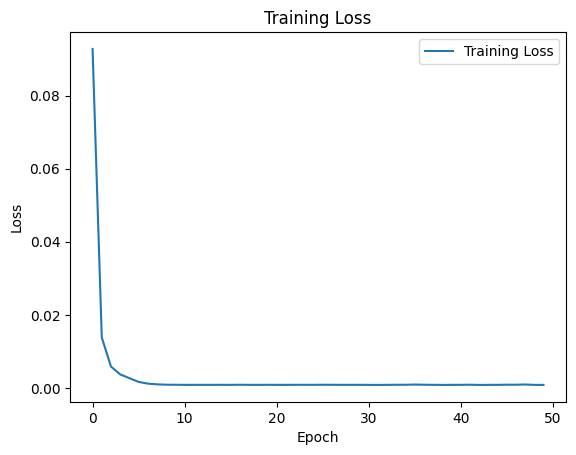

In [11]:
# Plot training loss
plot_loss(history)

3/3 [==============================] - 1s 4ms/step


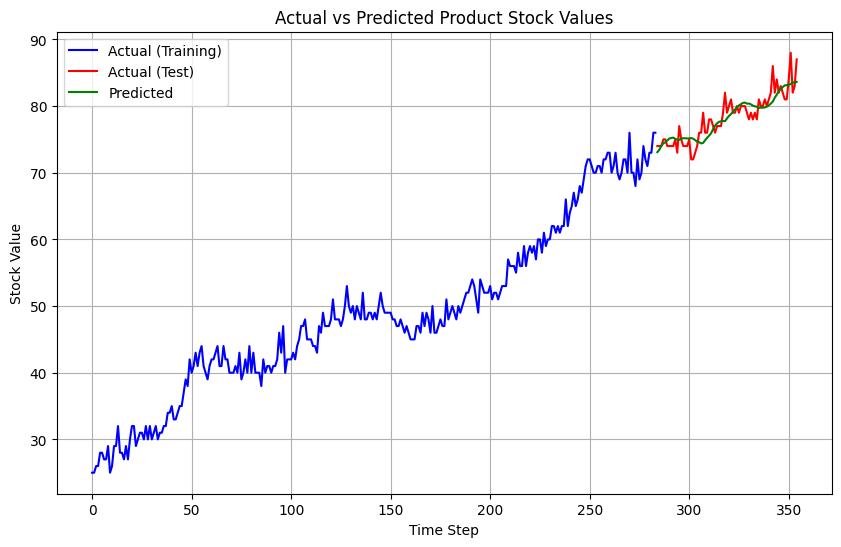

In [12]:
# Make predictions on the test set
predictions = predict(lstm_model, X_test, scaler)

# Plot actual vs predicted values
plot_predictions(product_stock_data["stock_data"][sequence_length:], predictions.flatten())

In [13]:
def mean_absolute_error(actual, predicted):
    """
    Calculate Mean Absolute Error (MAE).

    Parameters:
    - actual: numpy array or list, actual values
    - predicted: numpy array or list, predicted values

    Returns:
    - mae: float, Mean Absolute Error
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    mae = np.mean(np.abs(actual - predicted))
    return mae

test_size = int(0.2 * len(product_stock_data["stock_data"][sequence_length:]))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(product_stock_data["stock_data"][sequence_length:][-test_size:], predictions.flatten())
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 1.3339475175024758


In [14]:
# Save the trained LSTM model
lstm_model.save('lstm_model.h5')

# Save the scaler parameters
np.save('scaler_params.npy', [scaler.min_, scaler.scale_])

/home/Ayatsuri/Programs/Machine-Learning/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
